# Project scheduling
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://githubtocolab.com/PyJobShop/PyJobShop/blob/main/examples/project_scheduling.ipynb)

> If you're using this notebook in Google Colab, be sure to install PyJobShop first by executing ```pip install pyjobshop``` in a cell.

This notebook shows how to use PyJobshop to solve project scheduling problems, including the resource-constrained project scheduling problem (RCPSP) and the multi-mode resource-constrained project scheduling problem (MMRCPSP).

## Instances

[PSPLIB](https://www.om-db.wi.tum.de/psplib/main.html) is a benchmark library for project scheduling problems. Below we define a class for parsing and storing an instance from PSPLIB.

In [1]:
import re
from dataclasses import dataclass
from typing import NamedTuple


class Mode(NamedTuple):
    job: int
    duration: int
    demands: list[int]


@dataclass(frozen=True)
class Instance:
    """
    Problem instance class based on PSPLIB files.

    Code taken from:
    https://alns.readthedocs.io/en/latest/examples/resource_constrained_project_scheduling_problem.html
    """

    num_jobs: int  # jobs in RCPSP are tasks in PyJobshop
    num_resources: int
    successors: list[list[int]]
    predecessors: list[list[int]]
    modes: list[Mode]
    capacities: list[int]
    renewable: list[bool]

    @classmethod
    def read_instance(cls, path: str) -> "Instance":
        """
        Reads an instance of the RCPSP from a file.
        Assumes the data is in the PSPLIB format.
        """
        with open(path) as fh:
            lines = fh.readlines()

        prec_idx = lines.index("PRECEDENCE RELATIONS:\n")
        req_idx = lines.index("REQUESTS/DURATIONS:\n")
        avail_idx = lines.index("RESOURCEAVAILABILITIES:\n")

        successors = []

        for line in lines[prec_idx + 2 : req_idx - 1]:
            _, _, _, _, *jobs, _ = re.split(r"\s+", line)
            successors.append([int(x) - 1 for x in jobs])

        predecessors: list[list[int]] = [[] for _ in range(len(successors))]
        for job in range(len(successors)):
            for succ in successors[job]:
                predecessors[succ].append(job)

        mode_data = [
            re.split(r"\s+", line.strip())
            for line in lines[req_idx + 3 : avail_idx - 1]
        ]

        # Prepend the job index to mode data lines if it is missing.
        for idx in range(len(mode_data)):
            if idx == 0:
                continue

            prev = mode_data[idx - 1]
            curr = mode_data[idx]

            if len(curr) < len(prev):
                curr = prev[:1] + curr
                mode_data[idx] = curr

        modes = []
        for mode in mode_data:
            job_idx, _, duration, *consumption = mode
            demands = list(map(int, consumption))
            modes.append(Mode(int(job_idx) - 1, int(duration), demands))

        _, *avail, _ = re.split(r"\s+", lines[avail_idx + 2])
        capacities = list(map(int, avail))

        renewable = [
            x == "R"
            for x in lines[avail_idx + 1].strip().split(" ")
            if x in ["R", "N"]  # R: renewable, N: non-renewable
        ]

        return Instance(
            int(job_idx),
            len(capacities),
            successors,
            predecessors,
            modes,
            capacities,
            renewable,
        )

## Resource-constrained project scheduling

In the RCPSP, resources are no longer disjunctive resources that can only process one task at a time. Instead, resources have capacities and they can process multiple tasks simultaneously, and each task has a demand on the resource. Once a resource has finished a task, the demand is freed up again, that is, the resources are renewable. Tasks have a fixed duration and may consume multiple resources. Each task has a set of predecessors and successors, which are the tasks that must be completed before and after the current task, respectively. The goal of the RCPSP is to finish all tasks at minimum makespan.

Let's now create a Model class and define all problem data.

In [2]:
from pyjobshop import Model

instance = Instance.read_instance("data/j9041_6.sm")
model = Model()

# It's not necessary to define jobs, but it will add coloring to the plot.
jobs = [model.add_job() for _ in range(instance.num_jobs)]
tasks = [model.add_task(job=jobs[idx]) for idx in range(instance.num_jobs)]
resources = [model.add_renewable(capacity) for capacity in instance.capacities]

Next we define the processing modes of each task. A processing mode is one option for how to process a task: this includes the resources required for the task, the processing duration of the mode, and the demands for each resource. Unlike classical resource scheduling problems, we can require multiple resources at the same time.

In [3]:
for idx, duration, demands in instance.modes:
    model.add_mode(tasks[idx], resources, duration, demands)

And finally we add the precedence constraints.

In [4]:
for idx in range(instance.num_jobs):
    task = tasks[idx]

    for pred in instance.predecessors[idx]:
        model.add_end_before_start(tasks[pred], task)

    for succ in instance.successors[idx]:
        model.add_end_before_start(task, tasks[succ])

In [5]:
result = model.solve(time_limit=5, display=False)
print(result)

Solution results
  objective: 143.00
lower bound: 120.00
     status: Feasible
    runtime: 5.02 seconds


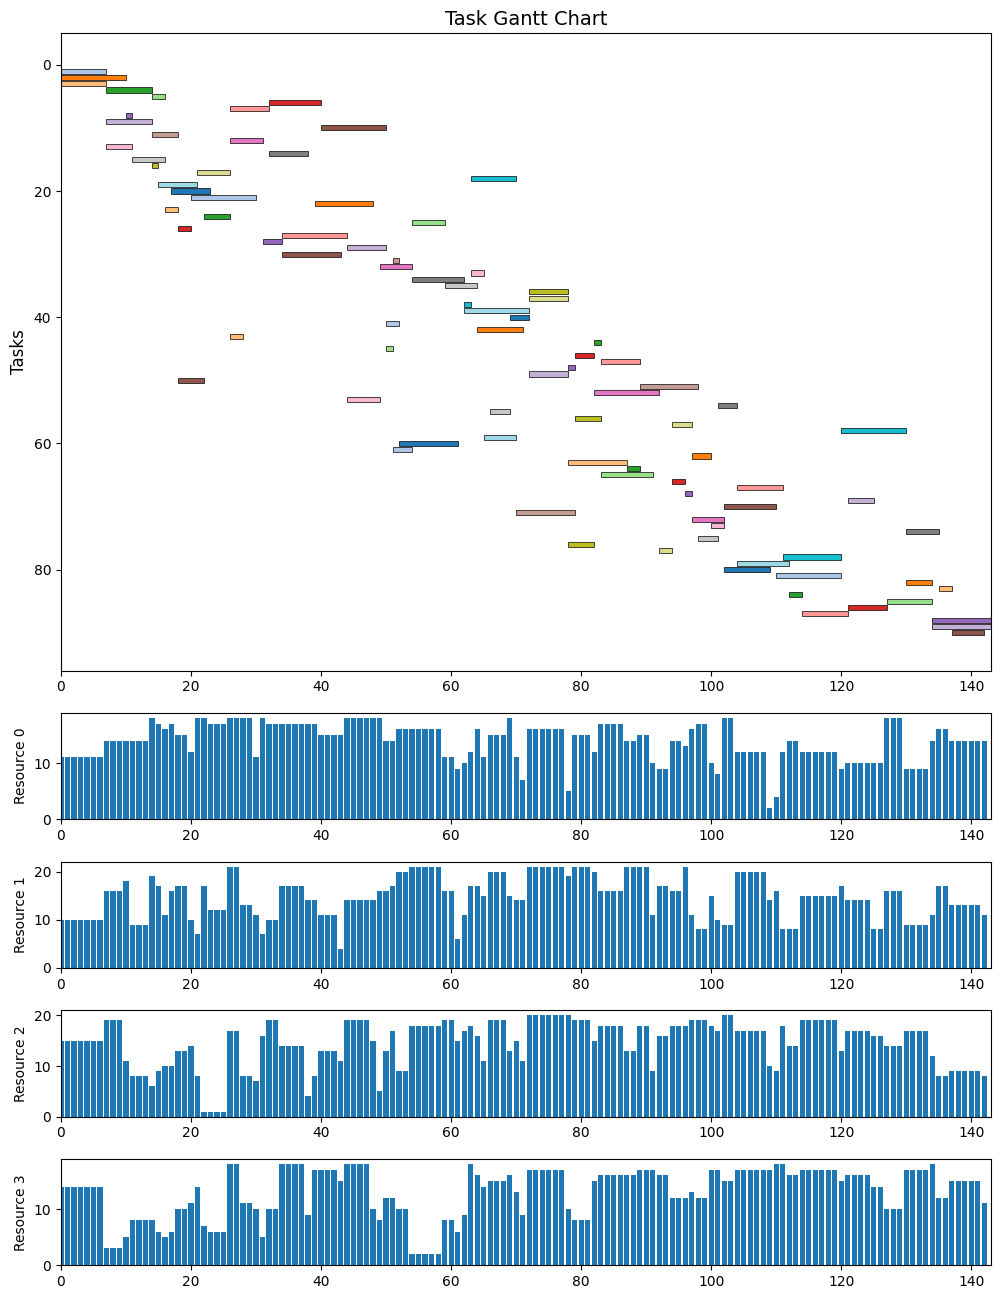

In [6]:
import matplotlib.pyplot as plt

from pyjobshop.plot import plot_resource_usage, plot_task_gantt

data = model.data()
fig, axes = plt.subplots(
    data.num_resources + 1,
    figsize=(12, 16),
    gridspec_kw={"height_ratios": [6] + [1] * data.num_resources},
)

plot_task_gantt(result.best, model.data(), ax=axes[0])
plot_resource_usage(result.best, model.data(), axes=axes[1:])

## Multi-mode resource-constrained project scheduling

In the RCPSP, each task has a single way of processing. The MMRCPSP is a variant of the RCPSP that allows for multiple processing modes of tasks. The objective is to minimize the makespan subject to resource constraints.

In [7]:
from pyjobshop import Model

instance = Instance.read_instance("data/r54_9.mm")
model = Model()

# It's not necessary to define jobs, but it will add coloring to the plot.
jobs = [model.add_job() for _ in range(instance.num_jobs)]
tasks = [model.add_task(job=jobs[idx]) for idx in range(instance.num_jobs)]
resources = [
    model.add_renewable(capacity=capacity)
    if renewable
    else model.add_non_renewable(capacity=capacity)
    for capacity, renewable in zip(instance.capacities, instance.renewable)
]

In [8]:
for idx, duration, demands in instance.modes:
    model.add_mode(tasks[idx], resources, duration, demands)

In [9]:
for idx in range(instance.num_jobs):
    task = tasks[idx]

    for pred in instance.predecessors[idx]:
        model.add_end_before_start(tasks[pred], task)

    for succ in instance.successors[idx]:
        model.add_end_before_start(task, tasks[succ])

In [10]:
result = model.solve(time_limit=5, display=False)
print(result)

Solution results
  objective: 54.00
lower bound: 54.00
     status: Optimal
    runtime: 0.02 seconds


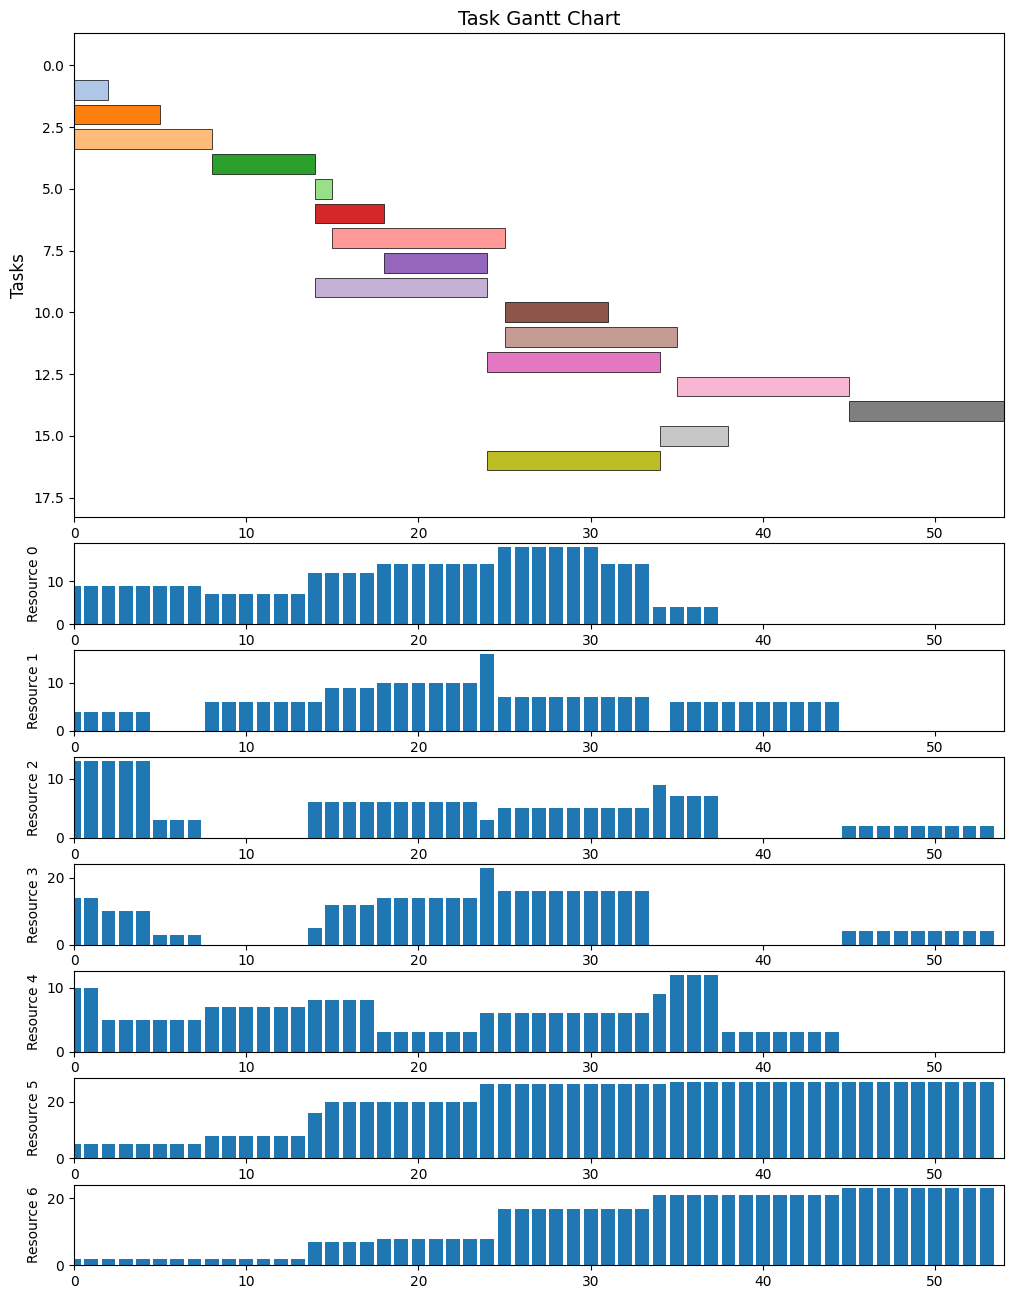

In [11]:
import matplotlib.pyplot as plt

from pyjobshop.plot import plot_resource_usage, plot_task_gantt

data = model.data()
fig, axes = plt.subplots(
    data.num_resources + 1,
    figsize=(12, 16),
    gridspec_kw={"height_ratios": [6] + [1] * data.num_resources},
)

plot_task_gantt(result.best, model.data(), ax=axes[0])
plot_resource_usage(result.best, model.data(), axes=axes[1:])